In [1]:
import pandas as pd
import time
from datetime import datetime
import geopandas as gpd
import shapely
import numpy as np
import cbsodata
from collections import Counter
import math

In [2]:
def VBOCleaner(data):
    from shapely.geometry import asPoint    
    # only keep objects with id
    data = data[data["identificatie"].notna()]    
    # only keep objects which are currently in use # CHECK of dit de juiste zijn
    data = data[data.verblijfsobjectStatus.isin(["Verblijfsobject gevormd", 
                                                 "Verblijfsobject in gebruik",
                                                 "Verblijfsobject in gebruik (niet ingemeten)"])]
    data = data[data.pos.notna()]    
    data["begindatumTijdvakGeldigheid"] =  pd.to_datetime(data['begindatumTijdvakGeldigheid'], format='%Y%m%d%H%M%S%f', errors='coerce')
    data["einddatumTijdvakGeldigheid"] =  pd.to_datetime(data['einddatumTijdvakGeldigheid'], format='%Y%m%d%H%M%S%f', errors='coerce')
    
    def toPoint(pos):
        string = "POINT " + str([float(i) for i in pos.split()[:2]])
        return string.replace("[", "(").replace("]", ")").replace(",", "")
    data.pos = data.pos.apply(toPoint)
    
    return data

In [3]:
def snapshotter(vbo, grid_vbo, buurtgrenzen, year):
    
    # Select only correct year
    d1 = datetime(year, 1, 1)
    vbo = vbo[vbo["begindatumTijdvakGeldigheid"] < d1] #pak vbo's die beginnen voor het jaar
    vbo = vbo[(vbo["einddatumTijdvakGeldigheid"] > d1) | (vbo["einddatumTijdvakGeldigheid"].isna())] #pak vbo's die stoppen na 

    print(sum(vbo.gebruiksdoelVerblijfsobject == "woonfunctie"))
    
    # Join VBO's to the grid
    data = grid_vbo.merge(vbo, how = "left", right_on = ["identificatie","pos"], left_on = ["identificatie","pos"])
    print(sum(data.gebruiksdoelVerblijfsobject == "woonfunctie"))

    # Add Buurt code to each vbo
    data.pos = data.pos.apply(shapely.wkt.loads)
    data = gpd.GeoDataFrame(data, geometry = "pos")
    data = gpd.sjoin(data, buurtgrenzen, op = "within", how = "left")
    
    # groupby grid code.
    data = data.join(pd.get_dummies(data.gebruiksdoelVerblijfsobject))
    data = data.drop("gebruiksdoelVerblijfsobject", axis = 1)
    data = data.groupby("C28992R100").agg({
        "bijeenkomstfunctie" : "sum",
        "gezondheidszorgfunctie" : "sum",
        "industriefunctie" : "sum",
        "kantoorfunctie" : "sum",
        "logiesfunctie" : "sum",
        "onderwijsfunctie" : "sum",
        "sportfunctie" : "sum",
        "winkelfunctie" : "sum",
        "woonfunctie" : "sum",
        "oppervlakteVerblijfsobject" : "median",
        "BU_CODE" : lambda x: Counter(x)
    })
    
    return data

In [4]:
def CBS_weighted_join(data, cbs):
    
    """
    returns cbs grid weigthed average
    """
    # create df to be filled
    df = pd.DataFrame(columns = np.append(["cbs100"], cbs.columns))
    l = len(data)
    n_cols = len(cbs.columns)
#     print(data.head())
#     print(cbs.head())
    
    # loop over data (grid)
    for j, (c, i) in enumerate(data.iterrows()):
        print("{:.2f}".format(j/l), end = "\r")
        
        # If the cell has a buurt code
        if type(i.BU_CODE) == Counter:
            
            total = 0
            ls = np.zeros(n_cols)
            
            # loop over the buurt codes (counter)
            for item in i.BU_CODE.items():
#                 print(cbs.loc[item[0]])
                # calculate weighted average
                ls += item[1] * cbs.loc[item[0]].values
                total += item[1]

            ls /= total
            df.loc[len(df)] = np.append(c, ls)
 
    df[cbs.columns.values] = df[cbs.columns.values].astype(np.float32)  
    return data.join(df.set_index("cbs100"), how = "left", rsuffix = "_r")
            


In [5]:
buurtgrenzen2015 = gpd.read_file("../Data/buurtgrenzen/2015/buurt_2015.shp")[["BU_CODE", "geometry"]]
buurtgrenzen2016 = gpd.read_file("../Data/buurtgrenzen/2016/buurt_2016.shp")[["BU_CODE", "geometry"]]
buurtgrenzen2017 = gpd.read_file("../Data/buurtgrenzen/2017/buurt_2017_v3.shp")[["BU_CODE", "geometry"]]
buurtgrenzen2018 = gpd.read_file("../Data/buurtgrenzen/2018/buurt_2018_v3.shp")[["BU_CODE", "geometry"]]
buurtgrenzen2019 = gpd.read_file("../Data/buurtgrenzen/2019/buurt_2019_v2up.shp")[["BU_CODE", "geometry"]]


VBO = pd.read_csv("VBO.csv", sep = ";", encoding = "utf-8", na_values = "NaN", on_bad_lines = "warn")
VBO = VBOCleaner(VBO)


In [52]:

# eindhoven vbo links eindhoven grids to vbos
grid_vbo = pd.read_csv("Eindhoven_vbo.csv")[["identificatie","C28992R100","pos"]]
grid_vbo = grid_vbo.drop_duplicates()

# full grid necessary since not all grids have vbo's so are not in grid_vbo
grid = pd.read_csv("Eindhoven_grid.csv", index_col = "C28992R100")
# grid.geometry = grid2015.geometry.apply(shapely.wkt.loads)

In [53]:
data2015 = snapshotter(VBO, grid_vbo, buurtgrenzen2015, 2015)
data2016 = snapshotter(VBO, grid_vbo, buurtgrenzen2016, 2016)
data2017 = snapshotter(VBO, grid_vbo, buurtgrenzen2017, 2017)
data2018 = snapshotter(VBO, grid_vbo, buurtgrenzen2018, 2018)
data2019 = snapshotter(VBO, grid_vbo, buurtgrenzen2019, 2019)
data2020 = snapshotter(VBO, grid_vbo, buurtgrenzen2019, 2020)

7579498
131167


C:\Users\Gebruiker\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'sterea', 'lat_0': 52.15616055555555, 'lon_0': 5.38763888888889, 'k': 0.9999079, 'x_0': 155000, 'y_0': 463000, 'ellps': 'bessel', 'units': 'm', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


7648521
134731


C:\Users\Gebruiker\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'sterea', 'lat_0': 52.15616055555555, 'lon_0': 5.38763888888889, 'k': 0.9999079, 'x_0': 155000, 'y_0': 463000, 'ellps': 'bessel', 'units': 'm', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


7706489
135954


C:\Users\Gebruiker\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'sterea', 'lat_0': 52.15616055555555, 'lon_0': 5.38763888888889, 'k': 0.9999079, 'x_0': 155000, 'y_0': 463000, 'ellps': 'bessel', 'units': 'm', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


7782031
138238


C:\Users\Gebruiker\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'sterea', 'lat_0': 52.15616055555555, 'lon_0': 5.38763888888889, 'k': 0.9999079, 'x_0': 155000, 'y_0': 463000, 'ellps': 'bessel', 'units': 'm', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


7875174
140966


C:\Users\Gebruiker\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'sterea', 'lat_0': 52.15616055555555, 'lon_0': 5.38763888888889, 'k': 0.9999079, 'x_0': 155000, 'y_0': 463000, 'ellps': 'bessel', 'units': 'm', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


7943656
143601


C:\Users\Gebruiker\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'sterea', 'lat_0': 52.15616055555555, 'lon_0': 5.38763888888889, 'k': 0.9999079, 'x_0': 155000, 'y_0': 463000, 'ellps': 'bessel', 'units': 'm', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [54]:
# ------------------ ------------------ ------------------ ------------------ ------------------ ------------------ ------------------ ------------------ ------------------ ------------------

In [58]:
data2015["y"] = (data2015.woonfunctie < data2016.woonfunctie).astype(int)
data2016["y"] = (data2016.woonfunctie < data2017.woonfunctie).astype(int)
data2017["y"] = (data2017.woonfunctie < data2018.woonfunctie).astype(int)
data2018["y"] = (data2018.woonfunctie < data2019.woonfunctie).astype(int)
data2019["y"] = (data2019.woonfunctie < data2020.woonfunctie).astype(int)

In [59]:
# data2015 = grid_full.join(data2015, rsuffix = "r")
# data2016 = grid_full.join(data2016, rsuffix = "r")
# data2017 = grid_full.join(data2017, rsuffix = "r")
# data2018 = grid_full.join(data2018, rsuffix = "r")
# data2019 = grid_full.join(data2019, rsuffix = "r")

data2015 = grid.join(data2015, rsuffix = "r")
data2016 = grid.join(data2016, rsuffix = "r")
data2017 = grid.join(data2017, rsuffix = "r")
data2018 = grid.join(data2018, rsuffix = "r")
data2019 = grid.join(data2019, rsuffix = "r")

In [60]:
data2015 = gpd.GeoDataFrame(data2015)
data2016 = gpd.GeoDataFrame(data2016)
data2017 = gpd.GeoDataFrame(data2017)
data2018 = gpd.GeoDataFrame(data2018)
data2019 = gpd.GeoDataFrame(data2019)
data2015.geometry = data2015.geometry.apply(shapely.wkt.loads)

<AxesSubplot:>

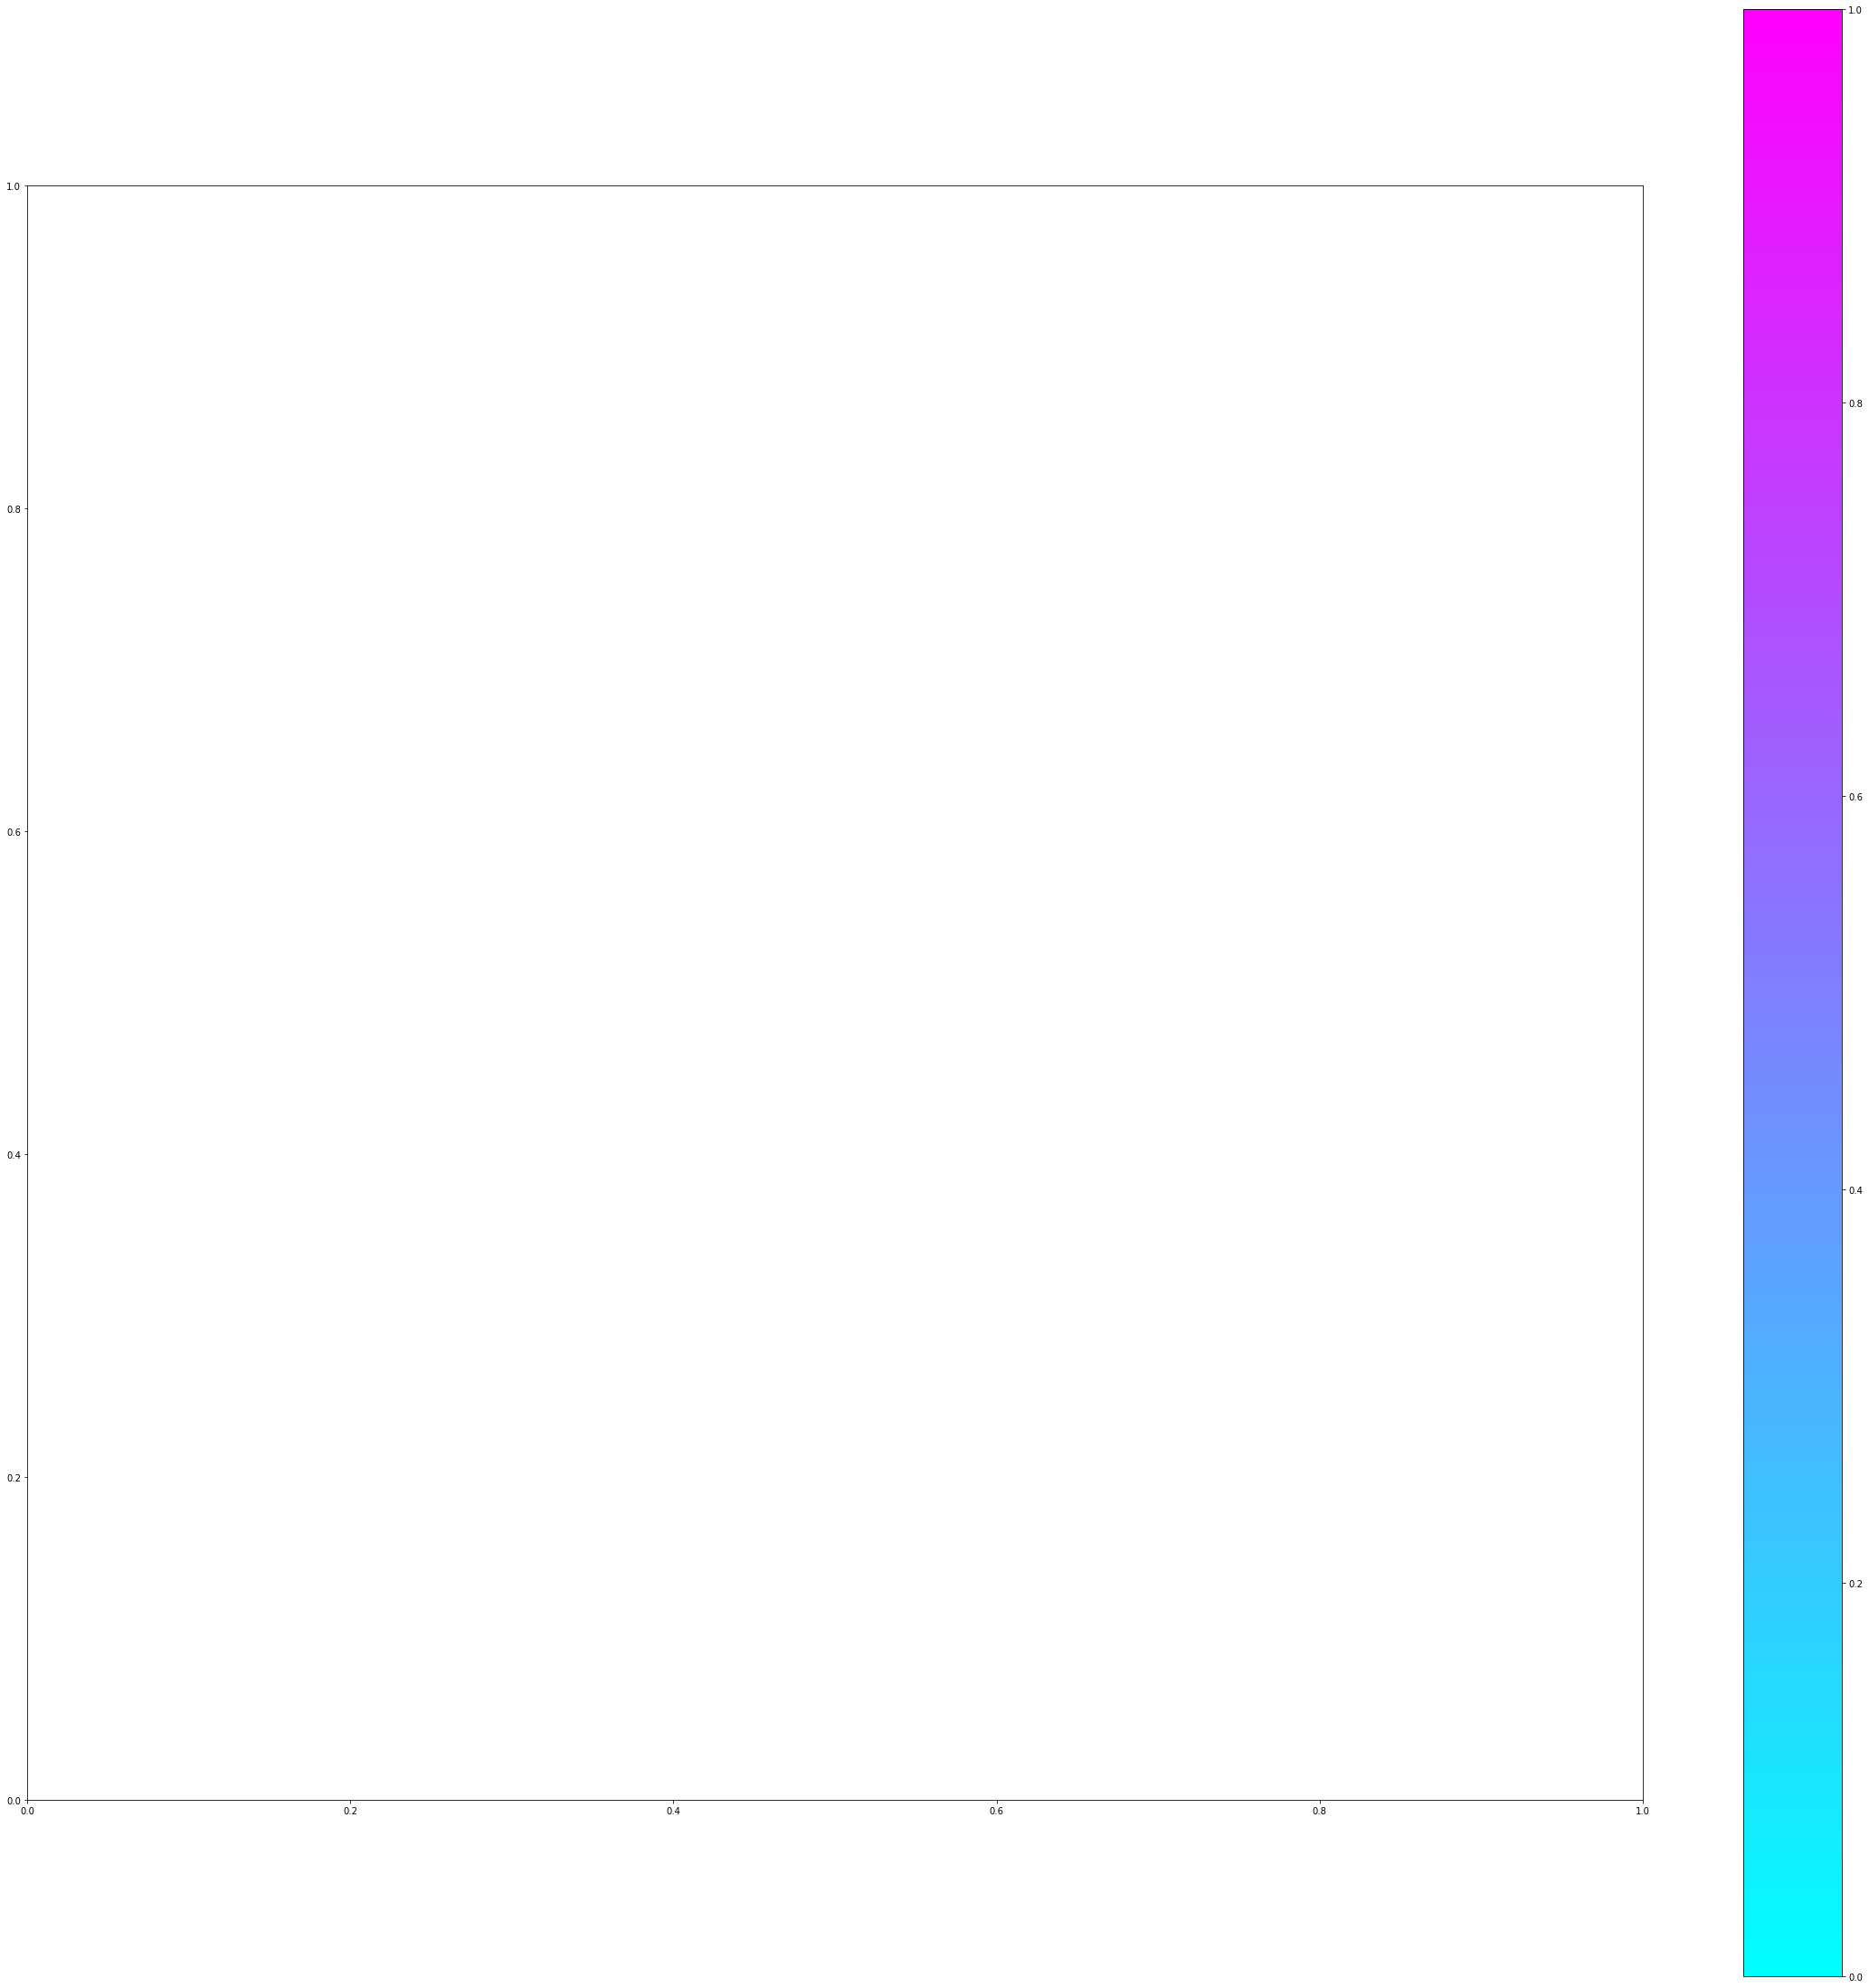

In [61]:
data2016.plot(figsize = (40,40), alpha=0.5, edgecolor = "b", column='y',cmap='cool',legend=True)

# Add CBS kerncijfers to data on grid level
Some overlaps with the buurtlevel nabijheidsgegevens, could be usefull to fill up gaps

In [62]:
cbs15 = gpd.read_file("../Data/cbs/2015/CBS_VK100_2015_v2.shp").set_index("C28992R100")
cbs16 = gpd.read_file("../Data/cbs/2016/CBS_VK100_2016_v2.shp").set_index("C28992R100")
cbs17 = gpd.read_file("../Data/cbs/2017/cbs_vk100_2017_v3.shp").set_index("c28992r100")
cbs18 = gpd.read_file("../Data/cbs/2018/CBS_VK100_2018_v3.shp").set_index("c28992r100")
cbs19 = gpd.read_file("../Data/cbs/2019/CBS_vk100_2019_v2.shp").set_index("c28992r100")
cbs15["WON_1524"] = 0

In [63]:
cbs_nab_variables = ["INWONER",
"GEBOORTE", # aantal geboortes
"INW_014", #inwoners 0-14
"INW_1524", # 15-24
"INW_2544", #etc
"INW_4564",# etc
"INW_65PL",# etc
"P_NL_ACHTG", # % NL achtergrond
"P_WE_MIG_A", # % western migration background
"P_NW_MIG_A", # % non-western migration background
"WONVOOR45", # n buildings before 45
"WON_4564", # between 45 - 65
"WON_6574", # etc
"WON_7584", # etc
"WON_8594", # etc
"WON_9504", # etc
"WON_0514", # etc
"WON_1524", # etc
# "WOZWONING", # median WOZ value  !! not in 2015/16/17/18
"P_KOOPWON", # % rental
"P_HUURWON", # % bought
"WON_HCORP", # n social housing
"M_INKHH", # median income (categorical)
# "P_LINK_HH", # percentage low income  !! not in 2015
# "P_HINK_HH", # percentage high income  !! not in 2015
"G_ELEK_WON", # average electricity use
"G_GAS_WON", # average gas yse
"UITKMINAOW", # n inhabitants with uitkering
"AFS_HAPRAK", # distance to huisarst praktrijk
"AFS_ZIEK_I", # distance to hospital with ... kliniek
"AFS_SUPERM", # distance to big supermarket
"AFS_ONDVRT", # distance to vo
"AFS_OPRIT", # dinstane to oprit big road
"AFS_TREINS", # distance to train statuib
"AFS_TRNOVS"] # distance to major transfer station

In [64]:
cbs15 = cbs15[cbs_nab_variables]
cbs16 = cbs16[cbs_nab_variables]
cbs17 = cbs17[cbs_nab_variables]
cbs18 = cbs18[cbs_nab_variables]
cbs19[['M_INKHH', 'AFS_HAPRAK', 'AFS_ZIEK_I', 'AFS_SUPERM', 'AFS_ONDVRT', 'AFS_OPRIT', 'AFS_TREINS', 'AFS_TRNOVS']] = np.NaN
cbs19 = cbs19[cbs_nab_variables]

In [65]:
cbs15["UITKMINAOW"] = cbs15["UITKMINAOW"].values / cbs15["INWONER"].values
cbs16["UITKMINAOW"] = cbs16["UITKMINAOW"].values / cbs16["INWONER"].values
cbs17["UITKMINAOW"] = cbs17["UITKMINAOW"].values / cbs17["INWONER"].values
cbs18["UITKMINAOW"] = cbs18["UITKMINAOW"].values / cbs18["INWONER"].values
cbs19["UITKMINAOW"] = cbs19["UITKMINAOW"].values / cbs19["INWONER"].values

In [66]:
tot15 = cbs15["WONVOOR45"] + cbs15["WON_4564"] + cbs15["WON_6574"] + cbs15["WON_7584"] + cbs15["WON_8594"] + cbs15["WON_9504"]+ cbs15["WON_0514"] + cbs15["WON_1524"]
tot16 = cbs16["WONVOOR45"] + cbs16["WON_4564"] + cbs16["WON_6574"] + cbs16["WON_7584"] + cbs16["WON_8594"] + cbs16["WON_9504"]+ cbs16["WON_0514"] + cbs16["WON_1524"]
tot17 = cbs17["WONVOOR45"] + cbs17["WON_4564"] + cbs17["WON_6574"] + cbs17["WON_7584"] + cbs17["WON_8594"] + cbs17["WON_9504"]+ cbs17["WON_0514"] + cbs17["WON_1524"]
tot18 = cbs18["WONVOOR45"] + cbs18["WON_4564"] + cbs18["WON_6574"] + cbs18["WON_7584"] + cbs18["WON_8594"] + cbs18["WON_9504"]+ cbs18["WON_0514"] + cbs18["WON_1524"]
tot19 = cbs19["WONVOOR45"] + cbs19["WON_4564"] + cbs19["WON_6574"] + cbs19["WON_7584"] + cbs19["WON_8594"] + cbs19["WON_9504"]+ cbs19["WON_0514"] + cbs19["WON_1524"]

cbs15["p_buildBefore2000_g"] = (cbs15["WONVOOR45"] + cbs15["WON_4564"] + cbs15["WON_6574"] + cbs15["WON_7584"] + cbs15["WON_8594"] + (cbs15["WON_9504"] / 2)) / tot15
cbs16["p_buildBefore2000_g"] = (cbs16["WONVOOR45"] + cbs16["WON_4564"] + cbs16["WON_6574"] + cbs16["WON_7584"] + cbs16["WON_8594"] + (cbs16["WON_9504"] / 2)) / tot16
cbs17["p_buildBefore2000_g"] = (cbs17["WONVOOR45"] + cbs17["WON_4564"] + cbs17["WON_6574"] + cbs17["WON_7584"] + cbs17["WON_8594"] + (cbs17["WON_9504"] / 2)) / tot17
cbs18["p_buildBefore2000_g"] = (cbs18["WONVOOR45"] + cbs18["WON_4564"] + cbs18["WON_6574"] + cbs18["WON_7584"] + cbs18["WON_8594"] + (cbs18["WON_9504"] / 2)) / tot18
cbs19["p_buildBefore2000_g"] = (cbs19["WONVOOR45"] + cbs19["WON_4564"] + cbs19["WON_6574"] + cbs19["WON_7584"] + cbs19["WON_8594"] + (cbs19["WON_9504"] / 2)) / tot19

cbs15["p_buildAfter2000_g"] = ((cbs15["WON_9504"] / 2) + cbs15["WON_0514"] + cbs15["WON_1524"]) / tot15
cbs16["p_buildAfter2000_g"] = ((cbs16["WON_9504"] / 2) + cbs16["WON_0514"] + cbs16["WON_1524"]) / tot16
cbs17["p_buildAfter2000_g"] = ((cbs17["WON_9504"] / 2) + cbs17["WON_0514"] + cbs17["WON_1524"]) / tot17
cbs18["p_buildAfter2000_g"] = ((cbs18["WON_9504"] / 2) + cbs18["WON_0514"] + cbs18["WON_1524"]) / tot18
cbs19["p_buildAfter2000_g"] = ((cbs19["WON_9504"] / 2) + cbs19["WON_0514"] + cbs19["WON_1524"]) / tot19

cbs15 = cbs15.drop(["WONVOOR45", "INW_4564", "WON_6574", "WON_7584", "WON_8594", "WON_9504", "WON_0514", "WON_1524"], axis = 1)
cbs16 = cbs16.drop(["WONVOOR45", "INW_4564", "WON_6574", "WON_7584", "WON_8594", "WON_9504", "WON_0514", "WON_1524"], axis = 1)
cbs17 = cbs17.drop(["WONVOOR45", "INW_4564", "WON_6574", "WON_7584", "WON_8594", "WON_9504", "WON_0514", "WON_1524"], axis = 1)
cbs18 = cbs18.drop(["WONVOOR45", "INW_4564", "WON_6574", "WON_7584", "WON_8594", "WON_9504", "WON_0514", "WON_1524"], axis = 1)
cbs19 = cbs19.drop(["WONVOOR45", "INW_4564", "WON_6574", "WON_7584", "WON_8594", "WON_9504", "WON_0514", "WON_1524"], axis = 1)

In [67]:
column_names = ["inwoner_g", "geboorte_g", "inw_014_g", "inw_1524_g", "inw_2544_g", "inw_4564_g", "inw_65_g",
               "p_NL_g", "p_wester_g", "p_nonWestern_g", "p_buyhouses_g", "p_rentals_g", "p_socialHousing_g",
               "medianIncome_g", "avg_electricity_g", "avg_gas_g", "p_benefits_g", "afs_haprak_g", "afs_ziek_g",
               "afs_superm_g", "afs_vo_g", "afs_oprit_g", "afs_treins_g", "afs_transit_g", "p_buildBefore2000_g",
               "p_buildAfter2000_g"]

In [68]:
cbs15.columns = column_names
cbs16.columns = column_names
cbs17.columns = column_names
cbs18.columns = column_names
cbs19.columns = column_names

In [69]:
data2015 = data2015.join(cbs15, how = "left")
data2016 = data2016.join(cbs16, how = "left")
data2017 = data2017.join(cbs17, how = "left")
data2018 = data2018.join(cbs18, how = "left")
data2019 = data2019.join(cbs19, how = "left")

In [70]:
# data2015.to_csv("grid2015.csv")
# data2016.to_csv("grid2016.csv")
# data2017.to_csv("grid2017.csv")
# data2018.to_csv("grid2018.csv")
# data2019.to_csv("grid2019.csv")

# add nabijheidsdata on buurt level to grid:


In [71]:
# koppel = pd.read_csv("../Data/grids_koppeling_gwb.csv", sep = ";")
# koppel = koppel.set_index("id_grid")
# koppel = koppel["id_buurt"]

In [72]:
# load all cbs nabijheidsstatistieken

cbs15 = pd.DataFrame(cbsodata.get_data('83304NED')).set_index("Codering_3")
cbs16 = pd.DataFrame(cbsodata.get_data('83749NED')).set_index("Codering_3")
cbs17 = pd.DataFrame(cbsodata.get_data('84334NED')).set_index("Codering_3")
cbs18 = pd.DataFrame(cbsodata.get_data('84463NED')).set_index("Codering_3")
cbs19 = pd.DataFrame(cbsodata.get_data('84718NED')).set_index("Codering_3")

In [73]:
cbs15.head()

,ID,Regio,Gemeentenaam_1,SoortRegio_2,AfstandTotHuisartsenpraktijk_4,Binnen1Km_5,Binnen3Km_6,Binnen5Km_7,AfstandTotHuisartsenpost_8,AfstandTotApotheek_9,...,Binnen5Km_104,Binnen10Km_105,Binnen20Km_106,AfstandTotSauna_107,AfstandTotZonnebank_108,AfstandTotAttractie_109,Binnen10Km_110,Binnen20Km_111,Binnen50Km_112,AfstandTotBrandweerkazerne_113
Codering_3,,,,,,,,,,,,,,,,,,,,,
NL00,0,Nederland,Nederland,Land,1.0,1.7,9.3,19.4,6.2,1.2,...,1.3,2.8,6.9,8.0,4.3,6.2,2.3,6.7,31.1,2.1
GM0003,1,Appingedam,Appingedam,Gemeente,1.3,0.2,1.0,2.3,3.9,1.3,...,0.2,1.0,1.0,21.6,21.9,17.3,0.0,1.0,11.2,1.3
WK000300,2,Wijk 00,Appingedam,Wijk,1.3,0.2,1.0,2.3,3.9,1.3,...,0.2,1.0,1.0,21.6,21.9,17.3,0.0,1.0,11.2,1.3
BU00030000,3,Appingedam-Centrum,Appingedam,Buurt,1.0,0.4,1.0,2.8,3.7,1.0,...,0.2,1.0,1.0,21.6,21.9,17.4,0.0,1.0,11.0,0.9
BU00030001,4,Appingedam-West,Appingedam,Buurt,1.6,0.0,1.0,1.7,4.7,1.6,...,0.0,1.0,1.0,22.4,22.2,17.8,0.0,1.0,11.7,0.7


In [74]:
# Only keep neighborhood related data (smallest area)
cbs15 = cbs15[cbs15.SoortRegio_2 == 'Buurt     ']
cbs16 = cbs16[cbs16.SoortRegio_2 == 'Buurt     ']
cbs17 = cbs17[cbs17.SoortRegio_2 == 'Buurt     ']
cbs18 = cbs18[cbs18.SoortRegio_2 == 'Buurt     ']
cbs19 = cbs19[cbs19.SoortRegio_2 == 'Buurt     ']


In [75]:
cbs15 = cbs15[["AfstandTotHuisartsenpraktijk_4",
"AfstandTotZiekenhuis_10",
"AfstandTotGroteSupermarkt_23",
"AfstandTotSchool_63",
# "AfstandTotOpenbaarGroenTotaal_75",  # Commented out: check why 16 - 19 only have nans
# "AfstandTotBos_78",
# "AfstandTotSportterrein_83",
"AfstandTotOpritHoofdverkeersweg_88",
"AfstandTotTreinstationsTotaal_89",
"AfstandTotBelangrijkOverstapstation_90"]]

cbs16 = cbs16[["AfstandTotHuisartsenpraktijk_5",
"AfstandTotZiekenhuis_11",
"AfstandTotGroteSupermarkt_24",
"AfstandTotSchool_64",
# "AfstandTotOpenbaarGroenTotaal_76",
# "AfstandTotBos_79",
# "AfstandTotSportterrein_84",
"AfstandTotOpritHoofdverkeersweg_89",
"AfstandTotTreinstationsTotaal_90",
"AfstandTotBelangrijkOverstapstation_91"]]

cbs17 = cbs17[["AfstandTotHuisartsenpraktijk_5",
"AfstandTotZiekenhuis_11",
"AfstandTotGroteSupermarkt_24",
"AfstandTotSchool_64",
# "AfstandTotOpenbaarGroenTotaal_91",
# "AfstandTotBos_94",
# "AfstandTotSportterrein_99",
"AfstandTotOpritHoofdverkeersweg_104",
"AfstandTotTreinstationsTotaal_105",
"AfstandTotBelangrijkOverstapstation_106"]]

cbs18 = cbs18[["AfstandTotHuisartsenpraktijk_5",
"AfstandTotZiekenhuis_11",
"AfstandTotGroteSupermarkt_24",
"AfstandTotSchool_64",
# "AfstandTotOpenbaarGroenTotaal_76",
# "AfstandTotBos_79",
# "AfstandTotSportterrein_84",
"AfstandTotOpritHoofdverkeersweg_89",
"AfstandTotTreinstationsTotaal_90",
"AfstandTotBelangrijkOverstapstation_91"]]

cbs19 = cbs19[["AfstandTotHuisartsenpraktijk_5",
"AfstandTotZiekenhuis_11",
"AfstandTotGroteSupermarkt_24",
"AfstandTotSchool_64",
# "AfstandTotOpenbaarGroenTotaal_76",
# "AfstandTotBos_79",
# "AfstandTotSportterrein_84",
"AfstandTotOpritHoofdverkeersweg_89",
"AfstandTotTreinstationsTotaal_90",
"AfstandTotBelangrijkOverstapstation_91"]]

In [76]:
# column_names = ["afs_huisarts_b","afs_ziekenhuis_b", "afs_supermarkt_b", "afs_school_b", 
#                  "afs_public_green_b", "afs_bos_b", "afs_sportterrein_b", "afs_oprit_b", 
#                 "afs_train_b", "afs_transit_b"]

column_names = ["afs_huisarts_b","afs_ziekenhuis_b", "afs_supermarkt_b", "afs_school_b", 
                 "afs_oprit_b", 
                "afs_train_b", "afs_transit_b"]

In [77]:
cbs15.columns = column_names
cbs16.columns = column_names
cbs17.columns = column_names
cbs18.columns = column_names
cbs19.columns = column_names

--> One grid 1 buurt per grid id

In [78]:
# data2015 = data2015.join(koppel, on = "rep_id", how = "left")
# data2016 = data2016.join(koppel, on = "rep_id", how = "left")
# data2017 = data2017.join(koppel, on = "rep_id", how = "left")
# data2018 = data2018.join(koppel, on = "rep_id", how = "left")
# data2019 = data2019.join(koppel, on = "rep_id", how = "left")

In [79]:
data2015 = CBS_weighted_join(data2015, cbs15)
data2016 = CBS_weighted_join(data2016, cbs16)
data2017 = CBS_weighted_join(data2017, cbs17)
data2018 = CBS_weighted_join(data2018, cbs18)
data2019 = CBS_weighted_join(data2019, cbs19)

In [80]:
# data2015.to_csv("grid2015.csv")
# data2016.to_csv("grid2016.csv")
# data2017.to_csv("grid2017.csv")
# data2018.to_csv("grid2018.csv")
# data2019.to_csv("grid2019.csv")

# add kerncijfers wijken en buurten

In [81]:
# data2015 = pd.read_csv("grid2015.csv")
# data2016 = pd.read_csv("grid2016.csv")
# data2017 = pd.read_csv("grid2017.csv")
# data2018 = pd.read_csv("grid2018.csv")
# data2019 = pd.read_csv("grid2019.csv")

In [82]:
# Get CBS kerncijfers wijken en buurten and set index at Regio ID for joining on grid data
cbs15 = pd.DataFrame(cbsodata.get_data('83220NED')).set_index("Codering_3")
cbs16 = pd.DataFrame(cbsodata.get_data('83487NED')).set_index("Codering_3")
cbs17 = pd.DataFrame(cbsodata.get_data('83765NED')).set_index("Codering_3")
cbs18 = pd.DataFrame(cbsodata.get_data('84286NED')).set_index("Codering_3")
cbs19 = pd.DataFrame(cbsodata.get_data('84583NED')).set_index("Codering_3")

In [83]:
# Only keep data on buurt level (lowest level)
cbs15 = cbs15[cbs15.SoortRegio_2 == "Buurt     "]
cbs16 = cbs16[cbs16.SoortRegio_2 == "Buurt     "]
cbs17 = cbs17[cbs17.SoortRegio_2 == "Buurt     "]
cbs18 = cbs18[cbs18.SoortRegio_2 == "Buurt     "]
cbs19 = cbs19[cbs19.SoortRegio_2 == "Buurt     "]

In [84]:
variables1517 = ["AantalInwoners_5",
                 "k_0Tot15Jaar_8",
                 "k_15Tot25Jaar_9",
                 "k_25Tot45Jaar_10",
                 "k_45Tot65Jaar_11",
                 "k_65JaarOfOuder_12",
                "WestersTotaal_17",
                "NietWestersTotaal_18",
                "GeboorteTotaal_24",
                "GemiddeldeWoningwaarde_35",
                "Koopwoningen_40",
                "HuurwoningenTotaal_41",
                "InBezitWoningcorporatie_42",
                "BouwjaarVoor2000_45",
                "BouwjaarVanaf2000_46",
                "GemiddeldElektriciteitsverbruikTotaal_47",
                "GemiddeldAardgasverbruikTotaal_55",
                "GemiddeldInkomenPerInkomensontvanger_65",
                "k_40PersonenMetLaagsteInkomen_67",
                "k_20PersonenMetHoogsteInkomen_68",
                "PersonenPerSoortUitkeringBijstand_74",
                "PersonenPerSoortUitkeringAO_75",
                "PersonenPerSoortUitkeringWW_76"]

In [85]:
variables18 = ["AantalInwoners_5",
               "k_0Tot15Jaar_8",
                 "k_15Tot25Jaar_9",
                 "k_25Tot45Jaar_10",
                 "k_45Tot65Jaar_11",
                 "k_65JaarOfOuder_12",
"WestersTotaal_17",
"NietWestersTotaal_18",
"GeboorteTotaal_24",
"GemiddeldeWoningwaarde_35",
"Koopwoningen_40",
"HuurwoningenTotaal_41",
"InBezitWoningcorporatie_42",
"BouwjaarVoor2000_45",
"BouwjaarVanaf2000_46",
"GemiddeldElektriciteitsverbruikTotaal_47",
"GemiddeldAardgasverbruikTotaal_55",
"GemiddeldInkomenPerInkomensontvanger_68",
"k_40PersonenMetLaagsteInkomen_70",
"k_20PersonenMetHoogsteInkomen_71",
"PersonenPerSoortUitkeringBijstand_80",
"PersonenPerSoortUitkeringAO_81",
"PersonenPerSoortUitkeringWW_82"]

In [86]:
variables19 = ["AantalInwoners_5",
               "k_0Tot15Jaar_8",
                 "k_15Tot25Jaar_9",
                 "k_25Tot45Jaar_10",
                 "k_45Tot65Jaar_11",
                 "k_65JaarOfOuder_12",
"WestersTotaal_17",
"NietWestersTotaal_18",
"GeboorteTotaal_24",
"GemiddeldeWoningwaarde_35",
"Koopwoningen_40",
"HuurwoningenTotaal_41",
"InBezitWoningcorporatie_42",
"BouwjaarVoor2000_45",
"BouwjaarVanaf2000_46",
"GemiddeldElektriciteitsverbruikTotaal_47",
"GemiddeldAardgasverbruikTotaal_55",
"GemiddeldInkomenPerInkomensontvanger_71",
"k_40PersonenMetLaagsteInkomen_73",
"k_20PersonenMetHoogsteInkomen_74",
"PersonenPerSoortUitkeringBijstand_83",
"PersonenPerSoortUitkeringAO_84",
"PersonenPerSoortUitkeringWW_85"]

In [87]:
cbs15 = cbs15[variables1517]
cbs16 = cbs16[variables1517]
cbs17 = cbs17[variables1517]
cbs18 = cbs18[variables18]
cbs19 = cbs19[variables19]

In [88]:
cbs15[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]] = cbs15[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]].div(cbs15["AantalInwoners_5"], axis = 0)                 
cbs16[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]] = cbs16[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]].div(cbs15["AantalInwoners_5"], axis = 0)
cbs17[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]] = cbs17[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]].div(cbs15["AantalInwoners_5"], axis = 0)
cbs18[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]] = cbs18[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]].div(cbs15["AantalInwoners_5"], axis = 0)
cbs19[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]] = cbs19[["k_0Tot15Jaar_8", "k_15Tot25Jaar_9", "k_25Tot45Jaar_10", "k_45Tot65Jaar_11", "k_65JaarOfOuder_12"]].div(cbs15["AantalInwoners_5"], axis = 0)

In [89]:
column_names = ["Inwoners_b", "inw14_b", "inw24_b", "inw44_b", "inw64_b", "inw65_b", "western_b", "nonWestern_b", "birth_b", "mean_WOZ_b",
               "p_buyHouses_b", "p_rental_houses_b", "p_socialHousing_b", "p_buildBefore2000_b",
               "p_buildAfter2000_b", "avg_electicity_b", "avg_gas_b",
               "medianInkomen_b", "PLaagste40Inkomen_b", "PHoogste20Inkomen_b", "NBijstand", "NAO", "NWW"]

In [90]:
cbs15.columns = column_names
cbs16.columns = column_names
cbs17.columns = column_names
cbs18.columns = column_names
cbs19.columns = column_names

In [91]:
# make it so it correspons to the grid level data
cbs15["pBenefits_b"] = (cbs15["NAO"].values + cbs15["NWW"].values + cbs15["NBijstand"].values) / cbs15["Inwoners_b"].values
cbs16["pBenefits_b"] = (cbs16["NAO"].values + cbs16["NWW"].values + cbs16["NBijstand"].values) / cbs16["Inwoners_b"].values
cbs17["pBenefits_b"] = (cbs17["NAO"].values + cbs17["NWW"].values + cbs17["NBijstand"].values) / cbs17["Inwoners_b"].values
cbs18["pBenefits_b"] = (cbs18["NAO"].values + cbs18["NWW"].values + cbs18["NBijstand"].values) / cbs18["Inwoners_b"].values
cbs19["pBenefits_b"] = (cbs19["NAO"].values + cbs19["NWW"].values + cbs19["NBijstand"].values) / cbs19["Inwoners_b"].values

cbs15 = cbs15.drop(["NAO", "NWW", "NBijstand"], axis = 1)
cbs16 = cbs16.drop(["NAO", "NWW", "NBijstand"], axis = 1)
cbs17 = cbs17.drop(["NAO", "NWW", "NBijstand"], axis = 1)
cbs18 = cbs18.drop(["NAO", "NWW", "NBijstand"], axis = 1)
cbs19 = cbs19.drop(["NAO", "NWW", "NBijstand"], axis = 1)


C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [92]:
# Set tot percentage
cbs15["western_b"] = cbs15["western_b"].values / cbs15["Inwoners_b"].values
cbs16["western_b"] = cbs16["western_b"].values / cbs16["Inwoners_b"].values
cbs17["western_b"] = cbs17["western_b"].values / cbs17["Inwoners_b"].values
cbs18["western_b"] = cbs18["western_b"].values / cbs18["Inwoners_b"].values
cbs19["western_b"] = cbs19["western_b"].values / cbs19["Inwoners_b"].values

C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after remov

In [93]:
# Set to percentage
cbs15["nonWestern_b"] = cbs15["nonWestern_b"].values / cbs15["Inwoners_b"].values
cbs16["nonWestern_b"] = cbs16["nonWestern_b"].values / cbs16["Inwoners_b"].values
cbs17["nonWestern_b"] = cbs17["nonWestern_b"].values / cbs17["Inwoners_b"].values
cbs18["nonWestern_b"] = cbs18["nonWestern_b"].values / cbs18["Inwoners_b"].values
cbs19["nonWestern_b"] = cbs19["nonWestern_b"].values / cbs19["Inwoners_b"].values

C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after remov

In [94]:


data2015 = CBS_weighted_join(data2015, cbs15)
data2016 = CBS_weighted_join(data2016, cbs16)
data2017 = CBS_weighted_join(data2017, cbs17)
data2018 = CBS_weighted_join(data2018, cbs18)
data2019 = CBS_weighted_join(data2019, cbs19)

In [95]:
data2015.notna().sum()

Unnamed: 0             14715
rep_id                 14715
gm_code                14715
gm_naam                14715
lb_gridcod              6440
                       ...  
avg_gas_b               6846
medianInkomen_b         6731
PLaagste40Inkomen_b     6731
PHoogste20Inkomen_b     6731
pBenefits_b             7037
Length: 72, dtype: int64

In [96]:
data2015.to_csv("EHgrid2015.csv")
data2016.to_csv("EHgrid2016.csv")
data2017.to_csv("EHgrid2017.csv")
data2018.to_csv("EHgrid2018.csv")
data2019.to_csv("EHgrid2019.csv")

In [71]:
data2015.columns

Index(['Unnamed: 0', 'geometry', 'bijeenkomstfunctie',
       'gezondheidszorgfunctie', 'industriefunctie', 'kantoorfunctie',
       'logiesfunctie', 'onderwijsfunctie', 'sportfunctie', 'winkelfunctie',
       'woonfunctie', 'oppervlakteVerblijfsobject', 'BU_CODE', 'y',
       'inwoner_g', 'geboorte_g', 'inw_014_g', 'inw_1524_g', 'inw_2544_g',
       'inw_4564_g', 'inw_65_g', 'p_NL_g', 'p_wester_g', 'p_nonWestern_g',
       'p_buyhouses_g', 'p_rentals_g', 'p_socialHousing_g', 'medianIncome_g',
       'avg_electricity_g', 'avg_gas_g', 'p_benefits_g', 'afs_haprak_g',
       'afs_ziek_g', 'afs_superm_g', 'afs_vo_g', 'afs_oprit_g', 'afs_treins_g',
       'afs_transit_g', 'p_buildBefore2000_g', 'p_buildAfter2000_g',
       'afs_huisarts_b', 'afs_ziekenhuis_b', 'afs_supermarkt_b',
       'afs_school_b', 'afs_oprit_b', 'afs_train_b', 'afs_transit_b',
       'Inwoners_b', 'inw14_b', 'inw24_b', 'inw44_b', 'inw64_b', 'inw65_b',
       'western_b', 'nonWestern_b', 'birth_b', 'mean_WOZ_b', 'p_buyH

In [72]:
data2018.avg_gas_b.notna().sum()

3889

In [73]:
b15 = data2015[data2015.woonfunctie > 0]
b16 = data2016[data2016.woonfunctie > 0]
b17 = data2017[data2017.woonfunctie > 0]
b18 = data2018[data2018.woonfunctie > 0]
b19 = data2019[data2019.woonfunctie > 0]


In [74]:
data2016.BU_CODE.isna().sum()/len(data2016)

0.6555013309671694

In [75]:
for n, i in enumerate((b17.isna().sum() / len(b))):
    print(n, i)

NameError: name 'b' is not defined

In [ ]:
b.columns[17 ]

## ------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
for i in cbs15.columns:
    print(i)

In [11]:
VBO.tail()

,gebruiksdoelVerblijfsobject,oppervlakteVerblijfsobject,verblijfsobjectStatus,begindatumTijdvakGeldigheid,einddatumTijdvakGeldigheid,identificatie,pos
19501536,industriefunctie,1678.0,Verblijfsobject in gebruik (niet ingemeten),2015-10-28,2018-02-08,9.571000e+14,POINT (195783.622 353657.113)
19501538,bijeenkomstfunctie,170.0,Verblijfsobject gevormd,2016-03-23,2018-02-08,9.571000e+14,POINT (198049.808 356330.331)
19501540,bijeenkomstfunctie,230.0,Verblijfsobject gevormd,2016-03-23,2018-02-08,9.571000e+14,POINT (198048.701 356313.161)
19501542,woonfunctie,427.0,Verblijfsobject gevormd,2012-08-22,2018-02-08,9.571000e+14,POINT (200290.765 360276.139)
19501544,woonfunctie,224.0,Verblijfsobject gevormd,2016-04-12,2017-10-05,5.600100e+15,POINT (196354.013 355718.594)
